# Mini proyecto 4
## Sistema de recomendación de películas 🎬
## Made with 💖 by:
## -Acosta Imandt Daniel
## -Callejas Hérnandez Edgar
## -Garduño Mártinez Eduardo


Estaos interesados en crear sistemas de recomendación de peliculas dados los datos que se pueden encontrar en esta liga (https://grouplens.org/datasets/movielens/1m/) la cual es una base de datos de los ratings que le dieron diferentes usuarios(6040) a peliculas (3883).

Es decir queremos proponer un conjunto de sugerencias útiles para el usuario.
Para esto vamos a utilizar dos técnicas diferentes.
- Primero vamos a ver los géneros de las peliculas que tenemos en la base de datos y los vamos a mapear en un espacio $n-$dimensional,  donde $n=18$ es el número de géneros totlaes en la base de datos. Por otro lado vamos a juntar todas las peliculas que ha visto cada usuario y vamos a sumar todos los géneros que suele ver  dandole cierto peso a las calificaciones de esas peliculas.Por ultimo vamos a poner a cada usuario en ese espacio $n$-dimensional y encontrar la pelicula más cercana a este usurio.
- La segunda técnica que vamos autilizar es el modelo de factor latente, esta es utilizando los ratings de los usarios para poder inferir patrones de productos y usuarios, para esto se utilizan los vectores latentes, utilizando valores singulares (SVD). Esto lo hacemos para poder estimar los datos ausentes, es decir las peliculas que no tienen ningún rating por los usuarios, pero encotramos ciertas correlaciones entre usuarios y darle un rating previsto a estas peliculas gracias a las dadas por otros.

In [1]:
#Cargamos líbrerias
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import plotly as ply
import plotly.express as px
import seaborn as sns
from scipy.spatial import distance_matrix # para sacar la matriz de distanicas
!pip install scikit-surprise
from surprise import Reader, Dataset, SVD 
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise import accuracy
sns.set_style("darkgrid")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Carga de los datos

In [2]:
# Cargamos las bases de datos
#Base de datos de las peliculas

#como las bases de datos no venian en csv tuvimos que hacer unas modificaciones
movies= pd.read_csv('/content/movies.dat', 
                 sep="::", 
                 names=['movie_id','title','genres']
                 ,encoding='latin-1') 
#base de datos de los usuarios
users = pd.read_csv('/content/users.dat', 
                 sep="::", 
                 names=['id','genero','edad','ocupacion','zip-code'])

#base de datos de las raitings
ratings=pd.read_csv('/content/ratings.dat',sep='::', names=['UserID','MovieID','Rating','Timestamp'])
#base de datos del usuario dafelisioso
daf=pd.read_csv('/content/ratings.csv')


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


## limpieza de los datos exploratorio de los datos

In [3]:
daf['title']=daf["Name"] +' ('+ daf["Year"].astype(str) +')'  #Hacemos que el nombre de las peliculas esten en el mismo faromato

In [4]:
ratings=ratings.drop(['Timestamp'], axis=1) #eliminamos columnas que no nos interesanratings.tail()
ratings.head()

,UserID,MovieID,Rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [5]:
daf.head()    

,Date,Name,Year,Letterboxd URI,Rating,title
0,2020-11-20,The Queen's Gambit,2020,https://boxd.it/s1Ym,4.0,The Queen's Gambit (2020)
1,2020-11-20,Parasite,2019,https://boxd.it/hTha,5.0,Parasite (2019)
2,2020-11-20,The Trial of the Chicago 7,2020,https://boxd.it/kn3w,4.0,The Trial of the Chicago 7 (2020)
3,2020-11-20,Spider-Man: Into the Spider-Verse,2018,https://boxd.it/azpY,4.0,Spider-Man: Into the Spider-Verse (2018)
4,2020-11-20,Knives Out,2019,https://boxd.it/jWEA,4.0,Knives Out (2019)


In [6]:
mov=movies.merge(daf,left_on='title',right_on='title')
mov=mov.drop(['genres','Date','Name','Year','Letterboxd URI'], axis=1) #eliminamos columnas que no nos interesan
mov

,movie_id,title,Rating
0,101,Bottle Rocket (1996),3.0
1,123,Chungking Express (1994),4.5
2,215,Before Sunrise (1995),5.0
3,296,Pulp Fiction (1994),5.0
4,307,Three Colors: Blue (1993),3.5
5,356,Forrest Gump (1994),5.0
6,480,Jurassic Park (1993),4.0
7,541,Blade Runner (1982),3.0
8,588,Aladdin (1992),3.5
9,594,Snow White and the Seven Dwarfs (1937),3.0


In [7]:
mov=movies.merge(daf,left_on='title',right_on='title') #Juntamos las bases de datos de peliculas y de dafelisioso gracias al nombre de la pelicula
mov['UserID']=0 #le ponemos el id 0 a dafelisioso
mov=mov.drop(['title'], axis=1) #eliminamos columnas que no nos interesan
mov.rename(columns = {'movie_id':'MovieID'}, inplace = True) #cambiamos conmbre se columnas
mov = mov[['UserID',	'MovieID'	,'Rating']] #nos quedamos solo con unas

mov=pd.concat([mov,ratings]).reset_index(drop=True) #juntamos los ratings de dafelisioso con los otros y los vemos
mov.head()

,UserID,MovieID,Rating
0,0,101,3.0
1,0,123,4.5
2,0,215,5.0
3,0,296,5.0
4,0,307,3.5


## Análisis exploratorio de los datos

In [8]:
# Contamos el total de géneros que tiene cada pelicula
movies['genres']=movies['genres'].apply(lambda x:str.split(x,sep='|')) #Separamos y vemos los géneros
movies['totgen']=movies['genres'].apply(len) #vemos el total de géneros por pelicula
movies.tail()

,movie_id,title,genres,totgen
3878,3948,Meet the Parents (2000),[Comedy],1
3879,3949,Requiem for a Dream (2000),[Drama],1
3880,3950,Tigerland (2000),[Drama],1
3881,3951,Two Family House (2000),[Drama],1
3882,3952,"Contender, The (2000)","[Drama, Thriller]",2


In [9]:
px.bar(ratings['Rating'].value_counts(),title="Calificaciones totales").update_layout(xaxis_title="Rating", yaxis_title="Frecuencia",showlegend=False)

In [10]:
px.bar(daf['Rating'].value_counts(),title="Calificaciones de dafelisioso",).update_layout(xaxis_title="Rating", yaxis_title="Frecuencia",showlegend=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().



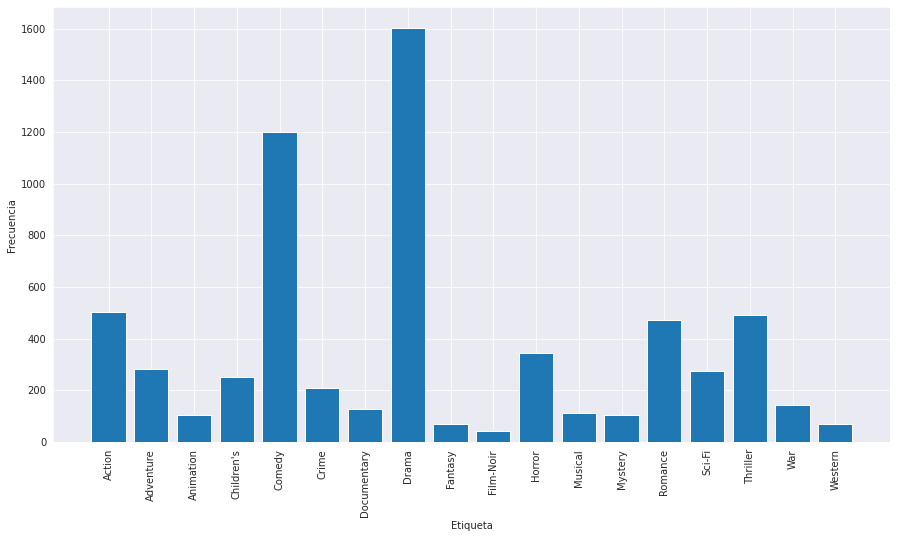

In [11]:
s1=pd.get_dummies(movies['genres'].apply(pd.Series).stack()).sum(level=0) #vemos los dummies de las peliculas, es decir uno si tiene ese género y cero si no
plt.figure(figsize=(15,8))
plt.bar(s1.columns, s1.sum())
plt.xticks(rotation='vertical')
plt.xlabel(u'Etiqueta')
plt.ylabel(u'Frecuencia')
plt.show()

# Clasificación basada en contenido

## Procesamiento de los datos para el primer algoritmo

In [12]:
movies2=pd.concat([movies, s1],axis=1) #juntamos los dummies con la base de las peliculas
movies2=movies2.drop(['genres','movie_id'], axis=1) #borramos columnas que no nos interesan
movies2=movies2.set_index('title') #ponemos el indice como el nombre de la peli
movies2.iloc[:,0:] = movies2.iloc[:,0:].div(movies2.totgen,axis=0) #hacemos que sume uno cada renglon
movies2=movies2.drop(['totgen'], axis=1)#borramos totgen
movies2.head()

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
title,,,,,,,,,,,,,,,,,,
Toy Story (1995),0.0,0.000000,0.333333,0.333333,0.333333,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Jumanji (1995),0.0,0.333333,0.000000,0.333333,0.000000,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Grumpier Old Men (1995),0.0,0.000000,0.000000,0.000000,0.500000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0
Waiting to Exhale (1995),0.0,0.000000,0.000000,0.000000,0.500000,0.0,0.0,0.5,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Father of the Bride Part II (1995),0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
print(ratings.shape) #vemos el tamaño original de ratings
#ratings = ratings.dropna() #eliminamos los vacios
ratings=pd.concat([s1,mov],axis=1)  #concatenamos las pleiculas con susdummies por renglón
ratings.head()

(1000209, 3)


,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,UserID,MovieID,Rating
0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,101,3.0
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,123,4.5
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,215,5.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,296,5.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,307,3.5


In [14]:
ratings = ratings[ratings.Rating >= 4] #eliminamos los menores  a 4
ratings=ratings.drop(['MovieID','Rating'], axis=1) #eliminamos columnas que no nos interesan

ratings['tot']=1 #creeamos una columna que sea 1 para todo renglon
ratings = ratings.groupby(['UserID']).sum() #agrupamos por  el usuario y sumamos sus generos que ve
ratings.iloc[:,0:] = ratings.iloc[:,0:].div(ratings.tot, axis=0) #dividimos por el total de pelicuals vistas
ratings=ratings.drop(['tot'], axis=1) #eliminamos la columna tot
print(ratings.shape)
ratings.index = ratings.index.astype(int)
#ratings['suma'] = ratings.sum(axis=1)
ratings.head(4)

(6039, 18)


,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
UserID,,,,,,,,,,,,,,,,,,
0,0.166667,0.125000,0.041667,0.083333,0.291667,0.083333,0.000000,0.416667,0.041667,0.0,0.000000,0.000000,0.000000,0.250000,0.083333,0.166667,0.041667,0.000000
1,0.111111,0.066667,0.022222,0.111111,0.311111,0.088889,0.022222,0.600000,0.044444,0.0,0.022222,0.044444,0.022222,0.200000,0.022222,0.200000,0.000000,0.000000
2,0.123288,0.082192,0.000000,0.054795,0.315068,0.041096,0.054795,0.452055,0.000000,0.0,0.041096,0.027397,0.027397,0.136986,0.082192,0.164384,0.013699,0.013699
3,0.054054,0.081081,0.027027,0.162162,0.351351,0.054054,0.027027,0.486486,0.054054,0.0,0.054054,0.027027,0.027027,0.162162,0.054054,0.135135,0.027027,0.027027


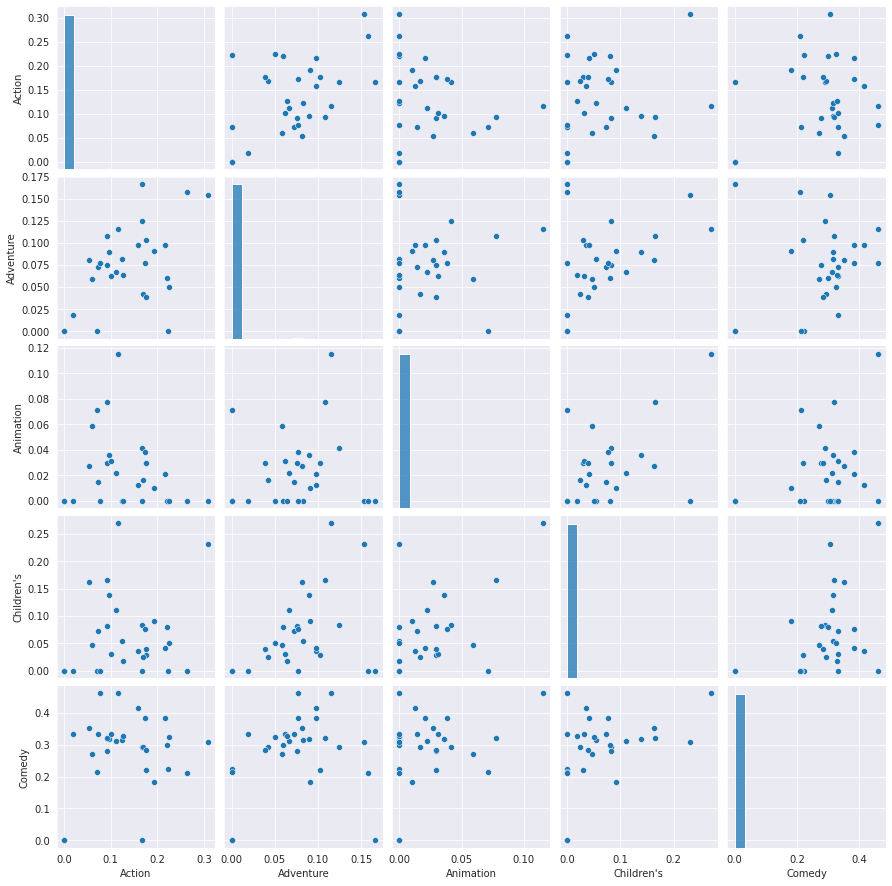

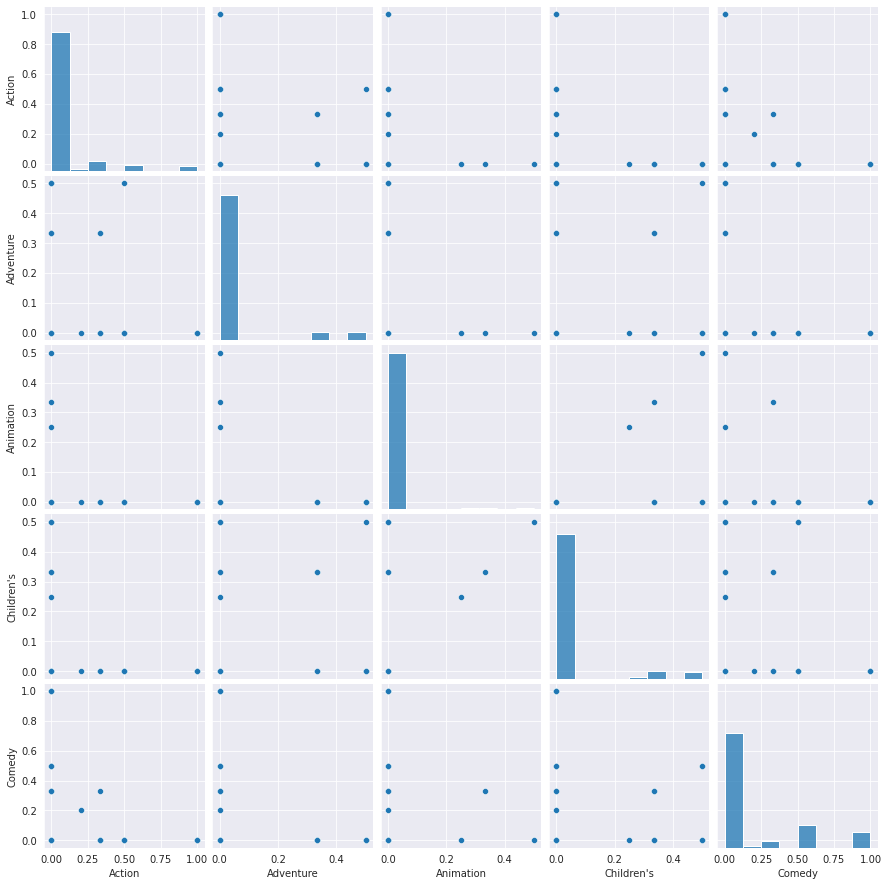

In [15]:
sns.pairplot(ratings.iloc[:,:5])
sns.pairplot(movies2.iloc[:100,:5])

Al comparar las posiciones de diferentes usuarios y de las peliculas notamos que en realidad este modelo de recomendación no es muy bueno, ya que por lo general las peliculas tienen pocos géneros entonces estas suelen estar a las orillas del espacio, mientras los usuarios suelen ver más peliculas de distintos tipos por lo que no van a soler estar en las orillas.

In [16]:
#Calculamos las distancias entre los vectores de usuarios y los vectores de las peliculas
distancias = distance_matrix(ratings,movies2)
distancias

array([[0.68844632, 0.76489832, 0.61378833, ..., 0.76489832, 0.76489832,
        0.57885183],
       [0.7856742 , 0.87488976, 0.7544109 , ..., 0.61664164, 0.61664164,
        0.52938352],
       [0.69002671, 0.79459927, 0.66130483, ..., 0.69661272, 0.69661272,
        0.52243709],
       ...,
       [0.57735027, 0.57735027, 0.70710678, ..., 1.        , 1.        ,
        0.70710678],
       [0.57735027, 0.57735027, 0.70710678, ..., 1.        , 1.        ,
        0.70710678],
       [0.57735027, 0.57735027, 0.70710678, ..., 1.        , 1.        ,
        0.70710678]])

## Algoritmo SVD


In [17]:
#Creamos la función de recomendaciones
def recomendacion(usuario,num_recom=3):
    """ 
        La función te indica una cantidad (num_recom) de peliculas recomendadas para el usuario con id (usuario)

        Input:
            usuario: Int, donde el número debe de ser el identificador del usuario
            num: Int, donde el número debe de ser el número de recomendaciones que desea ver
            
        Output:
            recomendaciones_f:List, donde se  entregan los nombres de las recomendaciones de las peliculas que o ha visto el usuario
    """

    #Guardamos el número del renglon asociado en la matriz de distancias al usuario
    indice = np.where(ratings.index == usuario)[0][0]

    #Guardamos el renglon asociado en la matriz de distancias al usuario
    peliculas = distancias[indice,:]

    #Ordenamos de acuerdo a las distancias (de menor a mayor)
    peliculas_ordenadas = np.argsort(peliculas)

    #Guardamos el ids de las peliculas ya ordenadas por distancia
    ids_peliculas = movies2.index[peliculas_ordenadas]
    #print(ids_peliculas)

    #Guardamos las peliculas que ya vio el usuario
    peliculas_vistas = list(ratings[ratings.index==usuario].iloc[:,1].values)
    #print(peliculas_vistas)

    #Creamos una lista auxiliar que guardara los ids de las recomendaciones
    recomendaciones_ids = []

    #Llenamos la lista de recomendaciones_ids
    for j in range(ids_peliculas.shape[0]):

        #Checamos que no haya visto la pelicula
        if not(ids_peliculas[j] in peliculas_vistas):
            recomendaciones_ids.append(ids_peliculas[j])

            #Checamos que sea el número de recomendaciones indicado
            if len(recomendaciones_ids) == num_recom:
                break

    print(recomendaciones_ids)

In [18]:
recomendacion(3)

['Jack Frost (1998)', 'Queens Logic (1991)', 'Muse, The (1999)']


In [19]:
recomendacion(0)

['About Last Night... (1986)', 'Fisher King, The (1991)', 'Brassed Off (1996)']


# Algoritmo SVD
Ahora debido a que digimos que el modelo anterior no era el más optimo vamos a hacerlo de otra manera el cual sera con descomposición de valores singulares (SVD), el cual utiliza el supuesto de que los elementos de la matriz estan altamente correlacionados y hay bastntes ceros en la matriz y se puede reconstruir los valores ausentes

In [20]:
movies=movies.set_index('movie_id')#hacemos el que indeex del df sea igual al index de la pelicula
movies['movie_id']=movies.index

In [21]:
"""Entrenar el modelo"""
my_seed = 101
random.seed(my_seed)
np.random.seed(my_seed)
reader = Reader() #Se utiliza para leer un dataset con calificaciones 
data = Dataset.load_from_df(mov, reader) #Traemos la base de datos completa

trainset, testset = train_test_split(data, test_size=.25) #dividimos los datos en conjunto de prueba y de entrenamiento
svd = SVD() #definición del modelo con el algoritmo SVD
#trainset = data.build_full_trainset()
svd.fit(trainset) #training

print("Rendimiento sobre conjunto de prueba")
predictions = svd.test(testset)
print(accuracy.rmse(predictions))


Rendimiento sobre conjunto de prueba
RMSE: 0.8772
0.8772180360279235


Notamos que el RMSE sobre los datos de prueba  es del 0.8772 mayor al 0.8525 que se obtuvo con cinematch con los datos de Netflix, considerando que con menos datos se obtuvo una mejor estimación es una grata noticia

In [22]:
def recomendacion2(id,movies=movies,cant=5):

    #    La función te indica una cantidad (cant) de peliculas recomendadas para el usuario con id (usuario)

     #   Input:
    #        id: Int, donde el número debe de ser el identificador del usuario
    #        cant: Int, donde el número debe de ser el número de recomendaciones que desea ver
            # movies base de datos de peliculas
    #    Output:
    #        movies:List, donde se  entregan los nombres de las recomendaciones de las peliculas que recomineda para el usuario
 #Primero imprimimos laspleiculas que ha visto el usuario y ha calificado
  user5 = mov[(mov['UserID'] == id) & (mov['Rating'] ==5)]
  user5 = user5.set_index('MovieID')
  user5 = user5.join(movies)['title']
  print("Películas que califico con 5 el usuario:"+str(id))
  print(user5)
  user4 = mov[(mov['UserID'] == id) & (mov['Rating'] ==4)]
  user4 = user4.set_index('MovieID')
  user4 = user4.join(movies)['title']
  print("Películas que califico con 4 el usuario:"+str(id))
  print(user4)
  user3 = mov[(mov['UserID'] == id) & (mov['Rating'] ==3)]
  user3 = user3.set_index('MovieID')
  user3 = user3.join(movies)['title']
  print("Películas que califico con 3 el usuario:"+str(id))
  print(user3)
  movies['Estimate_Score'] = movies['movie_id'].apply(lambda x: svd.predict(id, x).est) #Sacamos el score estimado gracias a svd predict
  movies = movies.sort_values('Estimate_Score', ascending=False) #ordenamos los valores de mayor a menor
  print('Te recomendamos las siguientes peliculas')
  return(movies.head(cant)) #imprimimos las peliculas mejor estimadas

In [23]:
recomendacion2(1)

Películas que califico con 5 el usuario:1
MovieID
1193    One Flew Over the Cuckoo's Nest (1975)
2355                      Bug's Life, A (1998)
1287                            Ben-Hur (1959)
2804                 Christmas Story, A (1983)
595                Beauty and the Beast (1991)
1035                Sound of Music, The (1965)
3105                         Awakenings (1990)
1270                 Back to the Future (1985)
527                    Schindler's List (1993)
48                           Pocahontas (1995)
1836            Last Days of Disco, The (1998)
1022                         Cinderella (1950)
150                           Apollo 13 (1995)
1                             Toy Story (1995)
1961                           Rain Man (1988)
1028                       Mary Poppins (1964)
1029                              Dumbo (1941)
2028                Saving Private Ryan (1998)
Name: title, dtype: object
Películas que califico con 4 el usuario:1
MovieID
3408                       

,title,genres,totgen,movie_id,Estimate_Score
movie_id,,,,,
2905,Sanjuro (1962),"[Action, Adventure]",2,2905,4.818799
1223,"Grand Day Out, A (1992)","[Animation, Comedy]",2,1223,4.766566
3134,"Grand Illusion (Grande illusion, La) (1937)","[Drama, War]",2,3134,4.734334
1949,"Man for All Seasons, A (1966)",[Drama],1,1949,4.720844
668,Pather Panchali (1955),[Drama],1,668,4.706226


In [24]:
recomendacion2(0)

Películas que califico con 5 el usuario:0
MovieID
215         Before Sunrise (1995)
296           Pulp Fiction (1994)
356           Forrest Gump (1994)
920     Gone with the Wind (1939)
1172       Cinema Paradiso (1988)
1673         Boogie Nights (1997)
3160              Magnolia (1999)
Name: title, dtype: object
Películas que califico con 4 el usuario:0
MovieID
480                          Jurassic Park (1993)
912                             Casablanca (1942)
924                  2001: A Space Odyssey (1968)
1193       One Flew Over the Cuckoo's Nest (1975)
1198               Raiders of the Lost Ark (1981)
1208                        Apocalypse Now (1979)
1213                            GoodFellas (1990)
1214                                 Alien (1979)
1259                           Stand by Me (1986)
1291    Indiana Jones and the Last Crusade (1989)
1907                                 Mulan (1998)
1961                              Rain Man (1988)
2918              Ferris Bueller's 

,title,genres,totgen,movie_id,Estimate_Score
movie_id,,,,,
296,Pulp Fiction (1994),"[Crime, Drama]",2,296,4.621466
2858,American Beauty (1999),"[Comedy, Drama]",2,2858,4.543818
2905,Sanjuro (1962),"[Action, Adventure]",2,2905,4.522589
318,"Shawshank Redemption, The (1994)",[Drama],1,318,4.401037
50,"Usual Suspects, The (1995)","[Crime, Thriller]",2,50,4.390658


In [25]:
mov2=movies.merge(daf,left_on='title',right_on='title')
mov2=mov2.drop(['genres','Date','Name','Year','Letterboxd URI','totgen'], axis=1) #eliminamos columnas que no nos interesan
mov2

,title,movie_id,Estimate_Score,Rating
0,Bottle Rocket (1996),101,3.614238,3.0
1,Chungking Express (1994),123,4.006486,4.5
2,Before Sunrise (1995),215,3.991293,5.0
3,Pulp Fiction (1994),296,4.621466,5.0
4,Three Colors: Blue (1993),307,3.797717,3.5
5,Forrest Gump (1994),356,4.148159,5.0
6,Jurassic Park (1993),480,3.193227,4.0
7,Blade Runner (1982),541,4.003000,3.0
8,Aladdin (1992),588,3.474540,3.5
9,Snow White and the Seven Dwarfs (1937),594,3.180617,3.0


## Conclusiones
Los sistemas de recomendación son muy usados hoy en día por practicamente todas las compañias de streaming ya que es muy importante poderle suministrar al usuario nuevas opciones que pueda disfrutar.
Como ya dijimos consideramos que el primer algoritmo que se implemento en esta libreta deja mucho que desear  ya que las peliculas suelen tener pocos géneros por lo que se suelen encontrar en las orillas del espacio mientras que los usuarios al ver bastantes preliculas y por lo gneral de difertnes géneros se encuentran más en el centro haciendo que se encuntren bastnte lejos de todas las pleiculas, ademas d eque muchas peliculas se van a encontrar en el mismo punto y solo va a recomdnear una de ellas.

Por el contrario el segundo algoritom el de SVD es muy bueno y quedamos profundamente maravillados por su presición a pesar de que cada usario no tenga muchos datos, esto ya que toma en cuenta la correlación entre los diferentes usuarios y gustos en común ,creando muy buenos resultados a la hora de estimar calificaciones como podemos ver en el ultimo dataframe.